In [121]:
import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())
try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0
tensorflow: 2.20.0 | GPUs: 0


In [122]:
import os, sys, json, time
from pathlib import Path

ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from finance_lstm import read_prices 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 
import numpy as np

with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

def _require(cfg, keys):
    miss = set(keys) - set(cfg)
    if miss:
        raise KeyError(f"Missing config keys: {sorted(miss)}")

_require(C, ["ticker","start","end","interval","horizon","lookback","batch","epochs"])

TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
HORIZON  = int(C["horizon"])
LOOKBACK = int(C["lookback"])
BATCH    = int(C["batch"])
EPOCHS   = int(C["epochs"])
SEED     = int(C.get("seed", 42))

RESULTS_DIR = Path(C.get("results_dir", "../results"))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV   = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
TRAIN_CSV = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}.csv"


In [123]:
df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

In [124]:
# --- Spalten robust vereinheitlichen ---
# MultiIndex? -> Ebene mit den Feldnamen (Open/High/...) finden
if isinstance(df.columns, pd.MultiIndex):
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    # Falls die untere Ebene die typischen Felder enthält, nimm die:
    if {"open","high","low","close","adj close","volume"} & set(bot):
        df.columns = df.columns.get_level_values(1)
    # Falls die obere Ebene die Felder enthält (selten), nimm die:
    elif {"open","high","low","close","adj close","volume"} & set(top):
        df.columns = df.columns.get_level_values(0)
    else:
        # Fallback: Wenn die obere Ebene überall der Ticker ist (aapl...),
        # dann nimm die untere Ebene.
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Spaltennamen normalisieren
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", ""))

# Wenn nur adjclose existiert, bau close daraus
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Index & Reihenfolge
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()].sort_index()

# Pflichtspalten prüfen (BEVOR du droppst):
required = {"open","high","low","close","volume"}
missing  = required - set(df.columns)
if missing:
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Numerik + NaNs raus
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=list(required), how="any")


In [125]:
# --- Quick sanity checks ---
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")
if df.index.has_duplicates:
    raise ValueError("Duplicate timestamps gefunden.")

print("Spalten final:", df.columns.tolist())
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2012-01-03 → 2025-08-29 | n = 3435


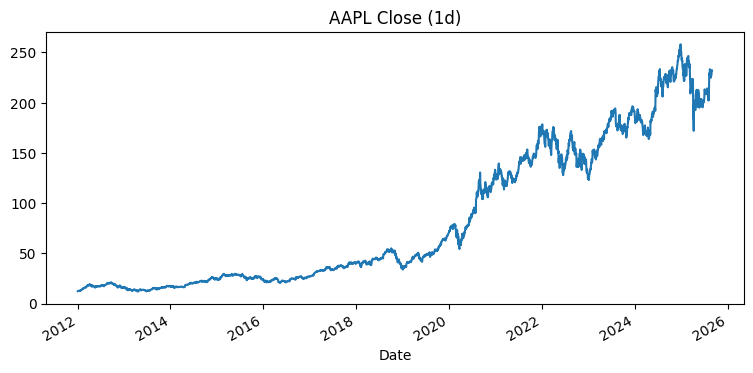

In [126]:
# --- Plot ---
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()

In [127]:
# --- CSV einfrieren (mit den standardisierten Namen) ---
os.makedirs("../data", exist_ok=True)
csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df.to_csv(csv_path)
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [128]:
# --- Manifest & Profiling ---
import hashlib, json

def _sha256_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

manifest = {
    "ticker": TICKER, "interval": INTERVAL, "start": START, "end": END,
    "rows": int(len(df)), "first_ts": str(df.index.min()), "last_ts": str(df.index.max()),
    "sha256": _sha256_file(csv_path),
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())
}
with open("../data/DATA_MANIFEST.json", "w") as f:
    json.dump(manifest, f, indent=2)

profiling = {
    "n": int(len(df)),
    "na_any": int(df.isna().any().any()),
    "close_min": float(df["close"].min()),
    "close_max": float(df["close"].max()),
    "logret_1d_mean": float(np.log(df["close"]).diff().dropna().mean()),
    "logret_1d_std": float(np.log(df["close"]).diff().dropna().std()),
}
with open("../data/profiling.json", "w") as f:
    json.dump(profiling, f, indent=2)

print("Manifest & Profiling geschrieben.")


Manifest & Profiling geschrieben.


In [129]:
import numpy as np, yaml, json
import pandas as pd
from finance_lstm import read_prices

In [130]:
# 0) RAW laden (einmal!)
raw_csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df_raw = read_prices(raw_csv_path)  # OHLCV (+adjclose), sauber & DatetimeIndex
assert (df_raw["close"] > 0).all(), "Close muss überall > 0 sein (für log)."

In [131]:
# 1) Features bauen (nur Vergangenheitsfunktionen)
def build_features(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out["logret_1d"] = np.log(out["close"]).diff()
    out["vola_10d"]  = out["logret_1d"].rolling(10, min_periods=10).std()
    out["sma_10"]    = out["close"].rolling(10, min_periods=10).mean()
    out["sma_20"]    = out["close"].rolling(20, min_periods=20).mean()
    out["sma_diff"]  = out["sma_10"] / out["sma_20"] - 1.0
    return out

df_feat = build_features(df_raw)

# 2) Target für den KONFIGURIERTEN HORIZON
future_log = np.log(df_feat["close"]).shift(-HORIZON)
curr_log   = np.log(df_feat["close"])
df_feat["target"] = ((future_log - curr_log) > 0).astype("int8")

# 3) Aufräumen: NaNs raus + (optional) Index sortieren
df_clean = df_feat.dropna().copy().sort_index()  # optional: .sort_index()

# 4) Artefakte: Feature-Metadaten + Trainings-CSV
feature_meta = {
    "name": "features_v1",
    "features": ["logret_1d","vola_10d","sma_10","sma_20","sma_diff"],
    "leakage_note": "Nur rückwärtsgerichtete Rolling/Diff – kein Future-Leakage."
}
with open("../data/features_v1.yml", "w") as f:
    yaml.safe_dump(feature_meta, f)

train_csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}.csv"
df_clean.to_csv(train_csv_out, float_format="%.8f")  # optional: float_format

# Zielverteilung
vc = df_clean["target"].value_counts().sort_index()
targets_summary = {
    "horizon": HORIZON,
    "n": int(len(df_clean)),
    "class_counts": {int(k): int(v) for k, v in vc.items()},
    "pos_rate": float(vc.get(1, 0) / vc.sum()) if vc.sum() else None,
}
with open("../data/targets_summary.json", "w") as f:
    json.dump(targets_summary, f, indent=2)

print("Train-CSV geschrieben:", train_csv_out)
print("targets_summary:", targets_summary)

Train-CSV geschrieben: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1.csv
targets_summary: {'horizon': 1, 'n': 3416, 'class_counts': {0: 1614, 1: 1802}, 'pos_rate': 0.5275175644028103}


In [132]:
# --- Checks & Vorschau ---
print("Spalten:", df_clean.columns.tolist())
print("Zeitraum:", df_clean.index.min().date(), "→", df_clean.index.max().date(), "| n =", len(df_clean))
print("\nVorschau:\n", df_clean[["close","logret_1d","target"]].head())
print("\nKlassenverteilung 0/1:", vc.to_dict(), "| Anteil 1:", round(vc.get(1,0)/vc.sum(), 3))

Spalten: ['open', 'high', 'low', 'close', 'volume', 'logret_1d', 'vola_10d', 'sma_10', 'sma_20', 'sma_diff', 'target']
Zeitraum: 2012-01-31 → 2025-08-29 | n = 3416

Vorschau:
                 close  logret_1d  target
Date                                    
2012-01-31  13.703584   0.007631       0
2012-02-01  13.694874  -0.000636       0
2012-02-02  13.662754  -0.002348       1
2012-02-03  13.799651   0.009970       1
2012-02-06  13.928436   0.009289       1

Klassenverteilung 0/1: {0: 1614, 1: 1802} | Anteil 1: 0.528


In [133]:
# --- Mini-Horizon-Demo (konsistent aus df_clean) ---
k = 100
if len(df_clean) <= max(k, HORIZON):
    raise ValueError("Zu wenige Zeilen für Mini-Demo. Wähle kleineren k oder prüfe HORIZON.")

i = df_clean.index[k]
pos_j = df_clean.index.get_loc(i) + HORIZON
if pos_j >= len(df_clean):
    raise IndexError("Index j liegt außerhalb des df_clean nach HORIZON-Shift.")
j = df_clean.index[pos_j]

print(f"\nHorizon-Check: {i.date()} -> {j.date()}")
print("close_i =", float(df_clean.loc[i, "close"]), " | close_j =", float(df_clean.loc[j, "close"]))
print("target_i =", int(df_clean.loc[i, "target"]))


Horizon-Check: 2012-06-22 -> 2012-06-25
close_i = 17.474706649780273  | close_j = 17.134580612182617
target_i = 0
